# Supervised learning
This tutorial is heavily indebted to [Jake Vanderplas' excellent notebook on SVMs](https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb)

It's best to learn by doing, so let's learn about supervised learning by doing some.

We'll walk through the application of one supervised learning algorithm in detail: **support vector machines (AKA SVMs)**

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivation: 

SVMs are a **discriminative** model: they produce some **decision boundary**, e.g., a line, that separates classes.

(Another class of model is a **generative** model, so named because it can generate examples that match the probabilities in the training data. But that's outside of the scope of this tutorial. Just know such models exist.)

Let's get some fake data with two classes:

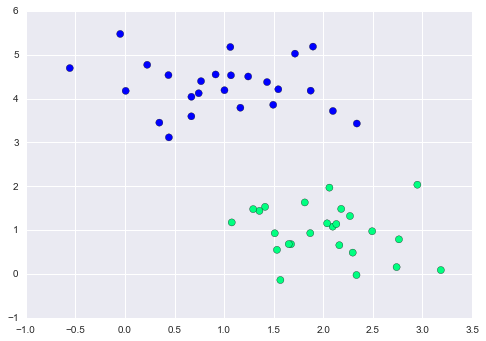

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

** How would you draw a line dividing these classes? **

Below I plot three possible lines.

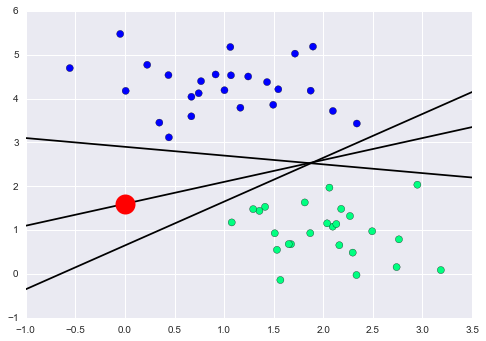

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);
plt.plot(0,1.6,'ro',markersize=20);

We see for a given point (e.g. the big red dot), our choice of dividing line could change what class it belongs to.

### Support Vector Machines maximize the *margin*

What support vector machined do is to not only draw a line, but consider a *region* about the line of some width.

The algorithm **maximizes** this region, known as the margin.

Here's an example of what that might look like, using our lines from above:

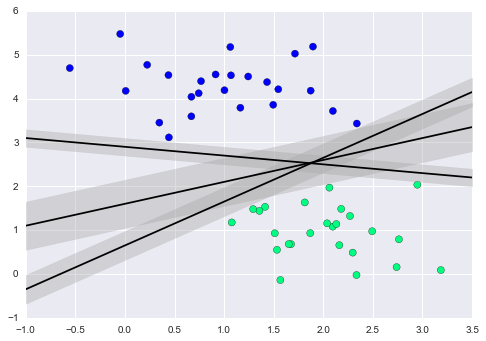

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Notice that the middle line would be the best in terms of maximizing the margin.

By eye, it appears to have the most "space" between the two groups.

#### Fitting a Support Vector Machine

Let's fit an SVM to these data points, using the scikit-learn API as we outlined before.

In [6]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear') # clf="classifier", convention in sk-learn examples
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's write a convenience function that helps us visualize the decision boundary for each SVM model:

In [7]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            point = np.asarray([xi, yj]).reshape(1, -1)
            P[i, j] = clf.decision_function(point)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

We run that function with our fitted model.

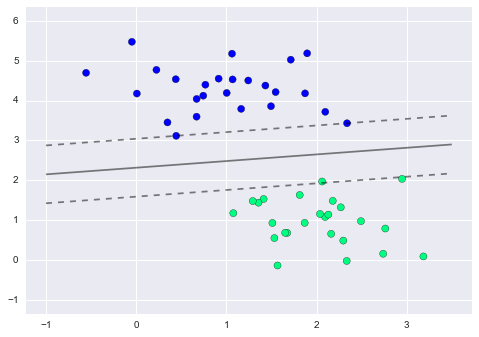

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf);

Below is an interactive function that plots the decision boundary for a dataset so we can compare what that boundary looks like for e.g. 10 points vs. 200 points.

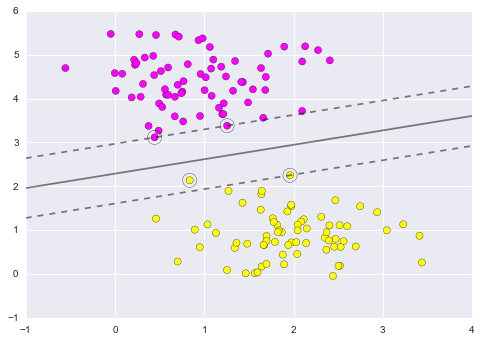

In [9]:
from ipywidgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
interact(plot_svm, N=[10, 200], kernel='linear');

The unique thing about SVMs is that the decision boundaries are represented by just the support vectors.

If you move any of the other points without letting them cross the decision boundaries, it has litle or no effect on what boundary is obtained by the algorithm.

#### Kernel Methods

SVMs become even more powerful when used in conjunction with *kernels*.

To motivate the need for kernels, let's look at some data which is not linearly separable:

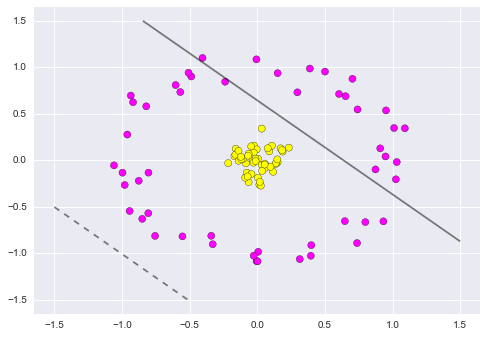

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Clearly, no linear discrimination will ever separate these data.
One way we can adjust this is to apply a **kernel**, which is some functional transformation of the input data.

For example, imagine that we add one dimension to our data:

that dimension is just the distance from the origin.

(We take the exponent of the distance to make it a Gaussian distribution.)

In [11]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

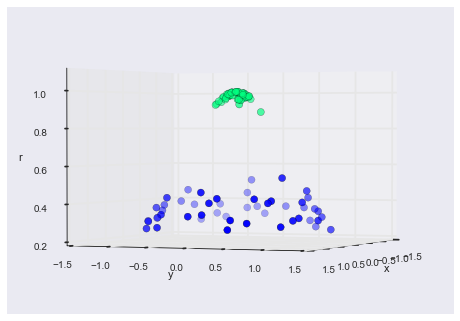

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

We can see that with this additional dimension, the data becomes trivially linearly separable!

This is a relatively simple kernel; SVM has a more sophisticated version of this kernel built-in to the process.

This is accomplished by using ``kernel='rbf'``, short for *radial basis function*:

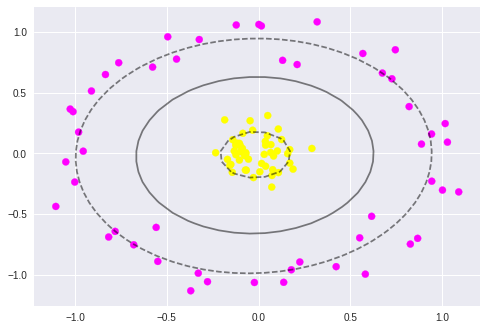

In [14]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Here there are effectively $N$ basis functions: one centered at each point! Through a clever mathematical trick, this computation proceeds very efficiently using the "Kernel Trick", without actually constructing the matrix of kernel evaluations.